# Lösungsvorschlag zu ÜA3 - Datensatz credt.csv

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Warungen ausblenden

## Überblick über die Daten


In [2]:
df = pd.read_csv("credit.csv")
df.shape

(409, 11)

Der Datensatz hat 400 Zeilen und 11 Features.

In [3]:
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Aufbau des Datensatzes

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     409 non-null    float64
 1   Limit      409 non-null    int64  
 2   Rating     409 non-null    int64  
 3   Cards      409 non-null    int64  
 4   Age        409 non-null    int64  
 5   Education  409 non-null    int64  
 6   Gender     409 non-null    object 
 7   Student    409 non-null    object 
 8   Married    409 non-null    object 
 9   Ethnicity  409 non-null    object 
 10  Balance    409 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 35.3+ KB


Hier sind die Datentypen der Features gelistet. Alle nicht-numerischen Werte müssen umgewandelt werden.

### Informationen zu Metadaten 

- Income: Einkommen in USD 
- Limit: Verfügbares Limit 
- Rating: Kreditwürdigkeit
- Cards: Anzahl Kreditkarten
- Age: Alter in Jahren
- Education: Anzahl der Bildungsjahre
- Gender: Geschlecht
- Student: Ist die Person Student
- Married: Ist die Person verheiratet
- Ethnicity: Ethnie der Person
- Balance: Höhe der Kreditkartenrechnung 


Aus der Aufgabenstellung ergeben sich folgende Informationen: Die Daten wurden ursprünglich zur Kundenstammanalyse verwendet. In diesem Datensatz sind Informationen über 400 Kreditkarteninhaber und ihre
demografischen Merkmale wie Alter, Geschlecht, Familienstand, ethnische
Herkunft, etc. enthalten.
Sie kommen aus https://www.kaggle.com/datasets/ishaanv/ISLR-Auto?select=Credit.csv.



## Beurteilung der Datenqualität

In [5]:
df.duplicated().sum()

9

Es sind neue Duplikate enthalten, die einfach entfernt werden.

In [6]:
df = df.drop_duplicates()
df.shape

(400, 11)

In [7]:
for col in df.columns:
    pct_missing = df[col].isnull().sum()
    print(f'{col} - {pct_missing :}')

Income - 0
Limit - 0
Rating - 0
Cards - 0
Age - 0
Education - 0
Gender - 0
Student - 0
Married - 0
Ethnicity - 0
Balance - 0


Es sind keine Fehlwertze enthalten. Der Dataframe wird etwas umsortiert, damit die Zielvariable Balance die erste Spalte einnimmt.

In [8]:
df = df[['Balance', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender', 'Student', 'Married', 'Ethnicity']]
df.head()

,Balance,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity
0,333,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian
1,903,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian
2,580,104.593,7075,514,4,71,11,Male,No,No,Asian
3,964,148.924,9504,681,3,36,11,Female,No,No,Asian
4,331,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian


## Bereinigung des Datensatzes und Explorative Datenanalyse

In [9]:
df_with_dum=pd.get_dummies(df,columns=["Gender","Student","Married","Ethnicity"], drop_first=True)

Einführen von Dummie Variablen für Gender, Student Married und Ethnicity. Die Variablen werden in boolean umgewandelt. Wobei Ethnicity in zwei boolean umgewandelt wird, da drei verschiedene Werte vertreten waren.

In [10]:
df_with_dum.head()

,Balance,Income,Limit,Rating,Cards,Age,Education,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,333,14.891,3606,283,2,34,11,0,0,1,0,1
1,903,106.025,6645,483,3,82,15,1,1,1,1,0
2,580,104.593,7075,514,4,71,11,0,0,0,1,0
3,964,148.924,9504,681,3,36,11,1,0,0,1,0
4,331,55.882,4897,357,2,68,16,0,0,1,0,1


Betrachtung der neuen Werte

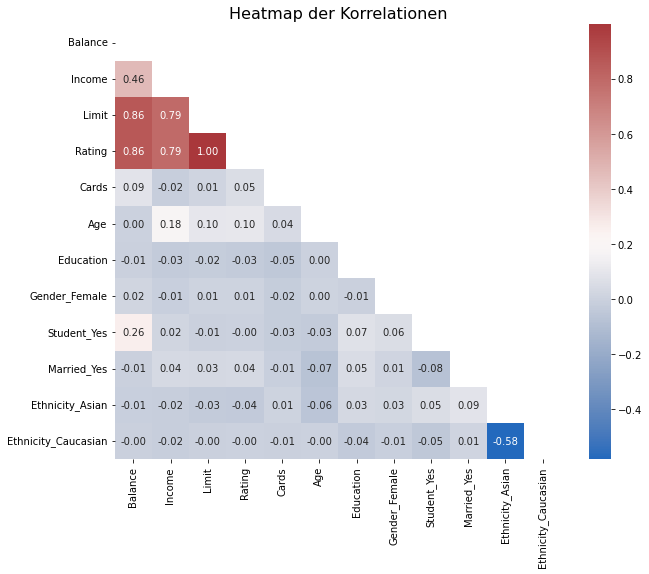

In [11]:
mask = np.triu(np.ones_like(df_with_dum.corr(), dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(df_with_dum.corr(), annot=True, fmt=".2f", mask=mask, cmap="vlag")
plt.title("Heatmap der Korrelationen", fontsize=16)
plt.show()

Anhand der Daten lässt sich sehen, dass Rating und Limit Korrelieren. Dies ergibt Sinn da sich eine hohe Kreditwürdigkeit natürlich im Kreditrahmen zeigen lässt.Eine weitere hohe Korrelation besteht zwischen Income und Rating und deswegen auch mit Limit. 
Es bietet sich an Rating oder Limit zu löschen, da sie beide nahezu dieselben Informationen enthalten.

In [12]:
df_with_dum=df_with_dum.drop("Rating", axis=1)

Löschen des Rating Features

In [13]:
df_with_dum.describe()

,Balance,Income,Limit,Cards,Age,Education,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.00000
mean,520.015000,45.218885,4735.600000,2.957500,55.667500,13.450000,0.517500,0.100000,0.61250,0.255000,0.49750
std,459.758877,35.244273,2308.198848,1.371275,17.249807,3.125207,0.500319,0.300376,0.48779,0.436407,0.50062
min,0.000000,10.354000,855.000000,1.000000,23.000000,5.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,68.750000,21.007250,3088.000000,2.000000,41.750000,11.000000,0.000000,0.000000,0.00000,0.000000,0.00000
50%,459.500000,33.115500,4622.500000,3.000000,56.000000,14.000000,1.000000,0.000000,1.00000,0.000000,0.00000
75%,863.000000,57.470750,5872.750000,4.000000,70.000000,16.000000,1.000000,0.000000,1.00000,1.000000,1.00000
max,1999.000000,186.634000,13913.000000,9.000000,98.000000,20.000000,1.000000,1.000000,1.00000,1.000000,1.00000


Bei der Betrachtung der statistischen Werte fällt auf, dass das erste Quartil bei Balance einen relativ kleinen Breich abdeckt. Die Verteilung sollte genauer betrachtet werden. 
Außerdem sollten die Features später skaliert werden, alle Wertebereiche sind unterschiedlich.

[Text(0.5, 1.0, 'Verteilung Balance')]

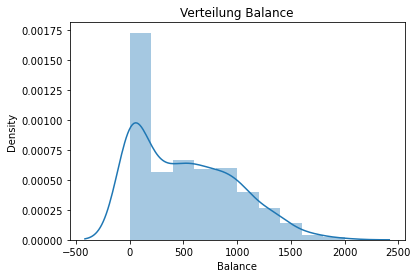

In [14]:
sns.distplot(df_with_dum["Balance"]).set(title="Verteilung Balance")

Viele Personen haben ihre Kreditkarte gar nicht genutzt. Da diese Daten das Training verfälschen würden, werden sie gelöscht. 

[Text(0.5, 1.0, 'Verteilung Balance ohne 0-Werte')]

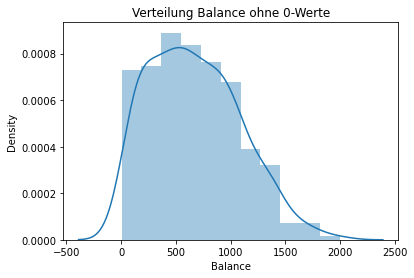

In [15]:
df_with_dum=df_with_dum[df_with_dum["Balance"]!=0]
sns.distplot(df_with_dum["Balance"]).set(title="Verteilung Balance ohne 0-Werte")

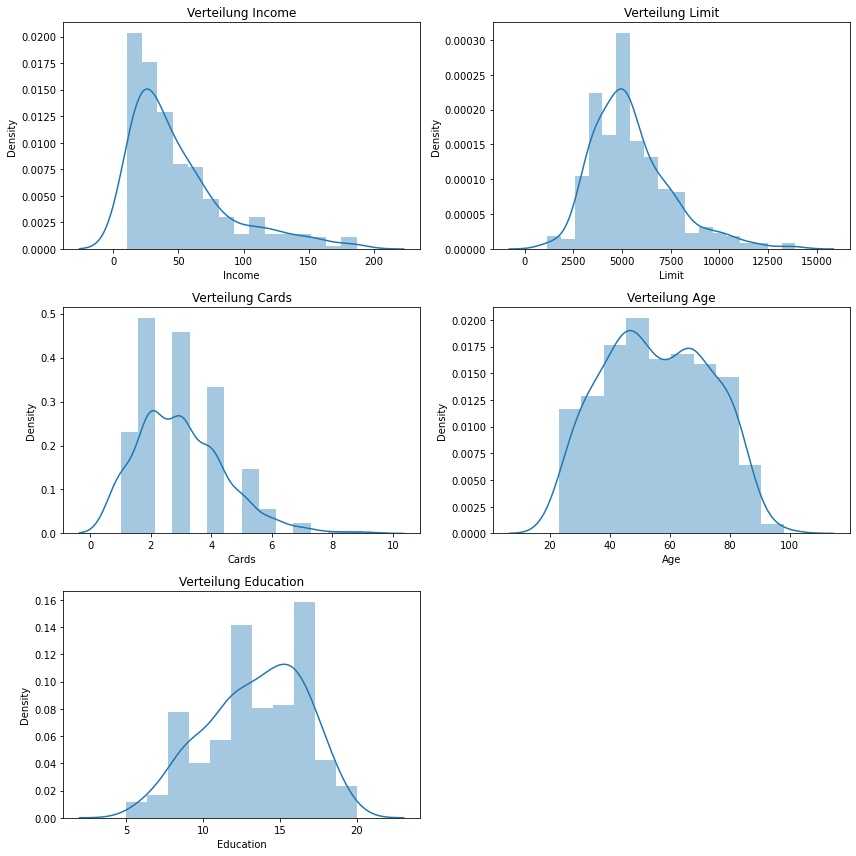

In [16]:
plt.figure(figsize=(12,12))

i=1
for feature in ["Income","Limit","Cards", "Age", "Education"]:
    plt.subplot(3,2,i)
    sns.distplot(df_with_dum[feature]).set(title="Verteilung " + feature)
    i=i+1
    
plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'Zuordnung zwischen Limit und Balance')]

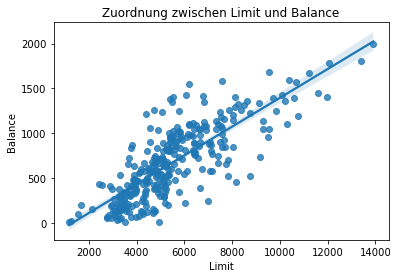

In [17]:
sns.regplot(df_with_dum, x="Limit"  ,y="Balance").set(title="Zuordnung zwischen Limit und Balance")

Streuplot zwischen Limit und Balance zeigt auffällige lineare Abhängigkeit.

[Text(0.5, 1.0, 'Zusammenhang Income und Balance')]

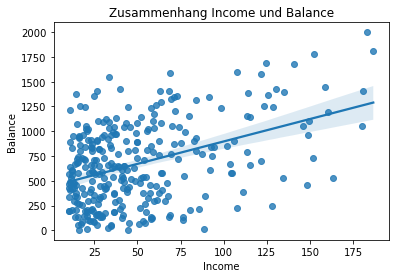

In [18]:
sns.regplot(df_with_dum, x="Income"  ,y="Balance").set(title="Zusammenhang Income und Balance")

[Text(0.5, 1.0, 'Zusammenhang Income und Limit')]

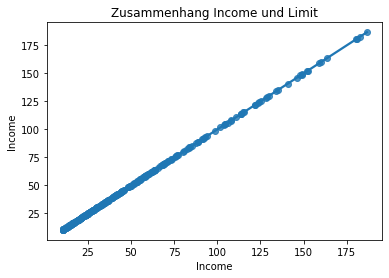

In [19]:
sns.regplot(df_with_dum, x="Income"  ,y="Income").set(title="Zusammenhang Income und Limit")

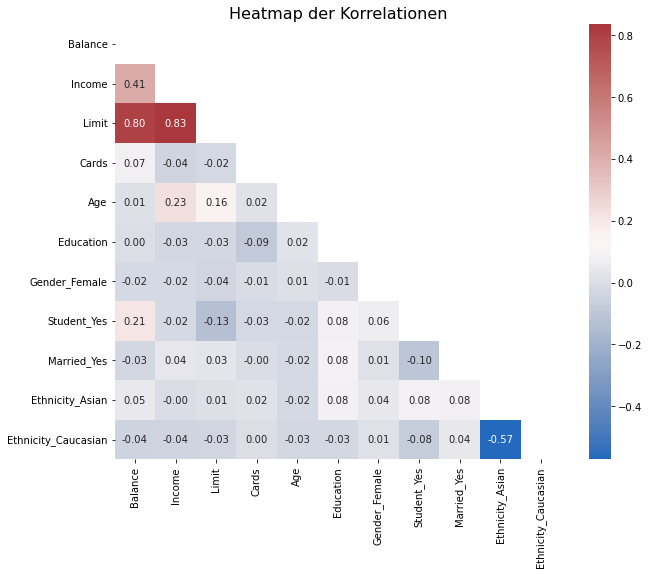

In [20]:
mask = np.triu(np.ones_like(df_with_dum.corr(), dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(df_with_dum.corr(), annot=True, fmt=".2f", mask=mask, cmap="vlag")
plt.title("Heatmap der Korrelationen", fontsize=16)
plt.show()

## Festlegung der Zielvariablen und splitten des Datensatzes in Train- und Testdatendatz

In [21]:
np.random.seed(0)
df_train, df_test = train_test_split(df_with_dum, train_size = 0.7, test_size = 0.3, random_state = 100)

In [22]:
scaler = MinMaxScaler()
num_vars = ['Balance', 'Income', 'Limit', 'Cards', 'Age','Education']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,Balance,Income,Limit,Cards,Age,Education,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
144,0.026714,0.040830,0.119479,0.285714,0.120000,0.600000,0,0,1,0,1
65,0.295867,0.009549,0.230836,0.428571,0.066667,0.600000,1,0,1,0,1
32,0.257560,0.718362,0.520899,0.142857,0.333333,0.533333,1,0,0,0,1
264,0.320565,0.102365,0.305521,0.000000,0.426667,0.333333,0,0,1,0,1
180,0.205645,0.001630,0.185410,0.571429,0.613333,0.733333,0,0,1,1,0


In [23]:
scaler = MinMaxScaler()
num_vars = ['Balance', 'Income', 'Limit', 'Cards', 'Age','Education']
df_test[num_vars] = scaler.fit_transform(df_test[num_vars])
df_test.head()

,Balance,Income,Limit,Cards,Age,Education,Gender_Female,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
93,0.516630,0.033463,0.348866,0.125,0.000000,0.769231,0,0,0,0,0
7,0.480599,0.345478,0.485882,0.125,0.968254,0.230769,0,0,0,1,0
327,0.542683,0.219136,0.448996,0.250,0.666667,0.615385,1,0,0,1,0
69,0.598115,0.221044,0.461808,0.375,0.460317,0.615385,0,0,1,0,1
201,0.578160,0.359713,0.503754,0.625,0.650794,0.692308,1,0,1,0,1


Die Zielvariable ist Balance und als Features werden alle außer Rating verwendet.
Ziel ist es, das Saldo der Kreditkarte anhand der gegebenen Daten vorherzusagen.

## Erstes Model: einfache lineare Regression - Zielvariable ist nur von Feature Limit abhängig

In [24]:
X_train=df_train["Limit"]
y_train=df_train["Balance"] 
X_test=df_test["Limit"]
y_test=df_test["Balance"]

In [25]:
import statsmodels.api as sm

# Addiere Konstante auf die X-Werte
X_train_sm = sm.add_constant(X_train)

# Fitten einer Regressionsgeraden mit Ordinary Least Squares 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()

# Übersicht über die Parameter
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     307.4
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           2.52e-43
Time:                        10:38:43   Log-Likelihood:                 136.35
No. Observations:                 217   AIC:                            -268.7
Df Residuals:                     215   BIC:                            -261.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.021     -0.037      0.9

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# test Vorhersage
y_pred1 = lr.predict(X_train_sm)
# Checkt den R^2 zwischen y-Test und y-Predicted
r_squared_1 = r2_score(y_train, y_pred1)
r_squared_1

0.5884359571937102

## Anwenden des Modells auf Testdaten

In [27]:
# Addiere Konstante auf X_test
X_test_sm = sm.add_constant(X_test)

# Vorhersage von y-Werten für X_test_sm
y_pred = lr.predict(X_test_sm)


In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Checkt den R^2 zwischen y-Test und y-Predicted
r_squared = r2_score(y_test, y_pred)
r_squared

0.695415805367336

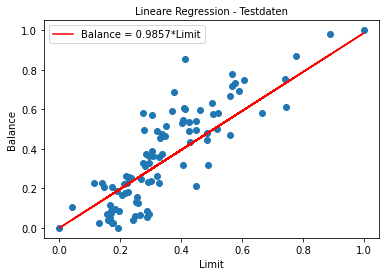

In [29]:
plt.scatter(X_test, y_test)
plt.plot(X_test, 0.9857 * X_test, 'r', label='Balance = 0.9857*Limit')
plt.title('Lineare Regression - Testdaten', fontsize=10)
plt.xlabel('Limit')
plt.ylabel('Balance')
plt.legend()
plt.show()

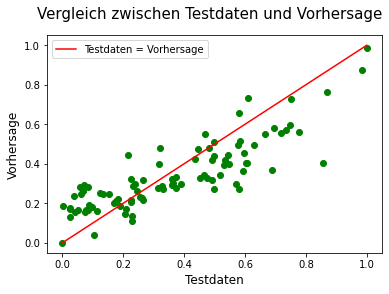

In [30]:
def linear_function(x):
    return 1* x

x_range = np.linspace(0, 1, 10)
y_function = linear_function(x_range)

fig = plt.figure()
plt.scatter(y_test,y_pred, c='g')
fig.suptitle('Vergleich zwischen Testdaten und Vorhersage', fontsize=15)
plt.xlabel('Testdaten', fontsize=12)
plt.ylabel('Vorhersage', fontsize=12)
plt.plot(x_range, y_function, label='Testdaten = Vorhersage', color='red')
plt.legend()
plt.show()

Auf den Testdaten erzielt das Model einen R2-score von rund 0.7, damit ist die Balance bereits robust vorhersagbar nur durch das Feature "Limit". (Achtung: die Werte sind noch MinMax-skaliert!)

## Zweites Model: Multiple lineare Regression

In [31]:
y_train2=df_train.pop('Balance')
X_train2=df_train
y_test2=df_test.pop('Balance')
X_test2=df_test

In [32]:
model_2 =LinearRegression()
model_2.fit(X_train2,y_train2)
y_pred2=model_2.predict(X_test2)
r2_2=r2_score(y_pred2,y_test2)
r2_2


0.9962629048363834

In [33]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
model_3 = LinearRegression()
model_3.fit(X_train2,y_train2)
rfe = RFE(model_3)
rfe = rfe.fit(X_train2, y_train2)
X_train2.columns[rfe.support_]

Index(['Income', 'Limit', 'Cards', 'Age', 'Student_Yes'], dtype='object')

In [35]:
X_train_rfe = X_train2[X_train2.columns[rfe.support_]]
X_test_rfe = X_test2[X_test2.columns[rfe.support_]]
model_4 =LinearRegression()
model_4.fit(X_train_rfe,y_train2)
y_pred4=model_4.predict(X_test_rfe)
r2_2=r2_score(y_pred4,y_test2)
r2_2

0.9962572496774807

In [36]:
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

checkVIF(X_train_rfe)

,Features,VIF
1,Limit,10.84
0,Income,5.83
3,Age,3.79
2,Cards,2.57
4,Student_Yes,1.09


In [37]:
X_train_new = X_train_rfe.drop(["Income"], axis = 1)
X_test_new = X_test_rfe.drop(["Income"], axis = 1)
checkVIF(X_train_new)
#model_5 =LinearRegression()
#model_5.fit(X_train_new,y_train2)
#y_pred5=model_5.predict(X_test_new)
#r2_2=r2_score(y_pred5,y_test2)
#r2_2

,Features,VIF
0,Limit,3.90
2,Age,3.74
1,Cards,2.43
3,Student_Yes,1.09


In [38]:
model_5 =LinearRegression()
model_5.fit(X_train_new,y_train2)
y_pred5=model_5.predict(X_test_new)
r2_2=r2_score(y_pred5,y_test2)
r2_2

0.6526148528683372

Unter Einbeziehung aller Features kann das Modell die Kreditkartenumsätze mit einem Bestimmtheitsmaß von über 99% vorhersagen.

### Evaluation des Linearen Models 


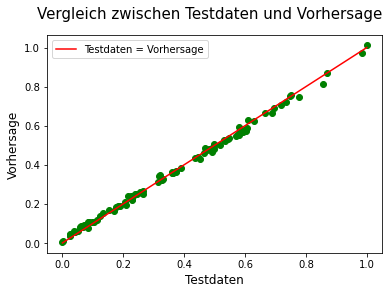

In [39]:
def linear_function(x):
    return 1* x

x_range = np.linspace(0, 1, 10)
y_function = linear_function(x_range)

fig = plt.figure()
plt.scatter(y_test2,y_pred4, c='g')
fig.suptitle('Vergleich zwischen Testdaten und Vorhersage', fontsize=15)
plt.xlabel('Testdaten', fontsize=12)
plt.ylabel('Vorhersage', fontsize=12)
plt.plot(x_range, y_function, label='Testdaten = Vorhersage', color='red')
plt.legend()
plt.show()

## Zusammenfassung und Modellvergleich Lineare Regression

Mit beiden getesteten Modellen wurden akzeptable Ergebnisse auf den Testdaten erzielt. Interessant ist dabei, dass auch die simple lineare Regression schon zu ca. 70% die Kreditkartenabrechnungen vorhersagen kann. Unter Einbeziehung aller Merkmale wird eine Anpassung von 99% erzielt. Es wäre anhand neuer Daten zu prüfen, ob das Modell jetzt eventuell overfitted ist...
**Nicht geprüft wurde hier bei diesem Beispiel, ob eventuell diverse Features zum Ergebnis nichts beitragen und daher aus der Analyse entfernt werden sollten.**

In [88]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train2, y_train2)

RandomForestRegressor(random_state=42)

In [89]:
y_pred_RF = random_forest.predict(X_test2)

In [90]:
rmse = mean_squared_error(y_test2, y_pred_RF, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)
# 'predictions' sind die Vorhersagen deines Modells
# 'y_test' sind die tatsächlichen Werte der Zielvariablen
r2_random_forest = r2_score(y_test2, y_pred_RF)
print("Bestimmtheitsmaß (R²):", r2_random_forest)

Root Mean Squared Error (RMSE): 0.07635281278169766
Bestimmtheitsmaß (R²): 0.9038398386982789


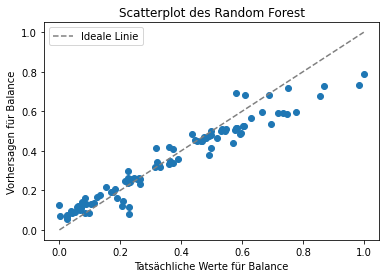

In [91]:
plt.scatter(y_test2, y_pred_RF)
plt.xlabel("Tatsächliche Werte für Balance")
plt.ylabel("Vorhersagen für Balance")
plt.title("Scatterplot des Random Forest")
# Regressionsgerade hinzufügen
x_line = np.linspace(y_test2.min(), y_test2.max(), 100)
y_line = x_line  # Annahme für die Gerade: y = x
plt.plot(x_line, y_line, color='grey', linestyle='--', label='Ideale Linie')

plt.legend()
plt.show()

Auch Random Forest erzeugt eine akzeptable Vorhersage mit R² = 0.9. Das schlechtere Abschneiden im Vergleich zur Linearen Regression kann an der geringen Anzahl der Datenpunkte liegen...

Vielleicht kann man mittels Untersuchung der Feature Importance das Modell noch etwas verbessern?

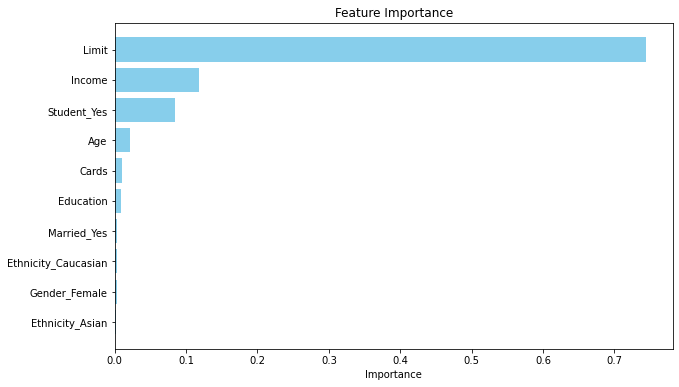

In [92]:
feature_importance = random_forest.feature_importances_

# Feature Importance in ein DataFrame zusammen mit den Spaltennamen einfügen
feature_importance_df = pd.DataFrame({'Feature': X_train2.columns, 'Importance': feature_importance})

# Sortieren der Features nach ihrer Importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Grafische Darstellung der Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Um die wichtigsten Features oben anzuzeigen
plt.show()

In [93]:
# einige Features tauchen in der Liste der important features gar nicht auf???
columns_to_drop = ['Cards', 'Age', 'Education', 'Ethnicity_Asian']
X_train2_drop = X_train2.drop(columns_to_drop, axis=1)


In [94]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train2_drop, y_train2)

RandomForestRegressor(random_state=42)

In [95]:
X_test2_drop = X_test2.drop(columns_to_drop, axis=1)
y_pred_RF2 = random_forest.predict(X_test2_drop)

In [96]:
rmse = mean_squared_error(y_test2, y_pred_RF2, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)
# 'predictions' sind die Vorhersagen deines Modells
# 'y_test' sind die tatsächlichen Werte der Zielvariablen
r2_random_forest = r2_score(y_test2, y_pred_RF2)
print("Bestimmtheitsmaß (R²):", r2_random_forest)

Root Mean Squared Error (RMSE): 0.0685955357983713
Bestimmtheitsmaß (R²): 0.9223865824688264


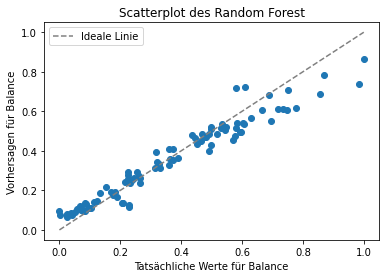

In [97]:
plt.scatter(y_test2, y_pred_RF2)
plt.xlabel("Tatsächliche Werte für Balance")
plt.ylabel("Vorhersagen für Balance")
plt.title("Scatterplot des Random Forest")
# Regressionsgerade hinzufügen
x_line = np.linspace(y_test2.min(), y_test2.max(), 100)
y_line = x_line  # Annahme für die Gerade: y = x
plt.plot(x_line, y_line, color='grey', linestyle='--', label='Ideale Linie')

plt.legend()
plt.show()

Mittels Feature selection konnte die Anpassung nochmals um 2 % verbessert werden (R² = 0.92).